# 0. Setup

## 0.1. Libraries

In [2]:
# Utilities
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

# Deep learning
import torch
from torch import nn, utils

# Custom library
from library import nn_model, utilities, visualizations, preprocessing

# Device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = torch.device(device)
print(f'Using device: {device}')

# Utilities
seed = 42
utilities.set_seed(seed)

Using device: cuda
Seed set to 42 for NumPy, Torch and Random for reproducibility.


## 0.2. Setting the path to the inference data

We set the path to the tiles that have been created in the preprocessing notebook, `3_preprocessing.ipynb`.

In [3]:
base_input_dir = '/media/pablo/Shared files/data/'  # Adjust this path to your data directory containing the inference dataset
tile_dir = os.path.join(base_input_dir, 'tiled_inference_dataset')  # Path to the tiled dataset
sentinel_type = 2  # Sentinel-2 data

## 0.3. Notebook description

We assess the severity of wildfires in Catalonia during the period 2015-2023, for fires *after* June 23rd, 2015 (the first date when Sentinel-2 L2A was available). As noted in the notebook `1_2`, data from Sentinel-2 L2A is almost complete for all wildfires registered in Catalunya between 2015 and 2023:
- 2015 is missing 8 images (8/13), mainly due to the fact that Sentinel-2 L2A was not available until June 23rd, 2015.
- 2016 is missing 3 images (3/16).
- 2017 is complete.
- 2018 is missing 1 satellite image (1/12).
- 2019 is missing 1 satellite image (1/27).
- 2020 is missing 3 images (3/11).
- 2021 is missing 2 images (2/22).
- 2022 is missing 3 images (3/43).
- 2023 is missing 1 image (1/21).

With this data, and given that the best-performing model observed is the one trained on Sentinel-2 images, we use the trained model to classify the inference tiles at the pixel level and to answer two different questions:
1. What has been the trend in the burnt area in the last decade (binary classification)?
2. Of the total area burned each year, has severity increased?

# 1. Preparing the data

## 1.1. Getting the image and masks paths

In [4]:
# Get all of the folders within the tiles directory
year_folders = sorted([f for f in os.listdir(tile_dir) if os.path.isdir(os.path.join(tile_dir, f))])
print("Year folders found:")
print(year_folders)
print("Total number of year folders:", len(year_folders))

# Create a dictionary to store paths for each year
year_image_paths = {}

for year_folder in year_folders:
    year_path = os.path.join(tile_dir, year_folder)
    
    # Get all Sentinel-2 files in this year folder
    sentinel_files = [f for f in os.listdir(year_path) 
                     if f.startswith(f'sentinel{sentinel_type}') and f.endswith('.tiff')]
    
    # Create full paths
    full_paths = [os.path.join(year_path, f) for f in sorted(sentinel_files)]
    
    # Store in dictionary
    year_image_paths[year_folder] = full_paths
    
    print(f"Year {year_folder}: {len(full_paths)} Sentinel-{sentinel_type} files")

# Print summary
total_images = sum(len(paths) for paths in year_image_paths.values())
print(f"\nTotal images across all years: {total_images}")

# Show sample paths from first year with data
for year, paths in year_image_paths.items():
    if paths:  # If this year has images
        print(f"\nSample paths from {year} (first 3):")
        for i, image in enumerate(paths[:3]):
            print(f"  {i+1}. {image}")
        break

# Convert to a flat list if needed for further processing
all_image_paths = [path for paths in year_image_paths.values() for path in paths]
print(f"\nFlat list created with {len(all_image_paths)} total images")

Year folders found:
['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Total number of year folders: 10
Year 2014: 0 Sentinel-2 files
Year 2015: 59 Sentinel-2 files
Year 2016: 98 Sentinel-2 files
Year 2017: 219 Sentinel-2 files
Year 2018: 66 Sentinel-2 files
Year 2019: 156 Sentinel-2 files
Year 2020: 42 Sentinel-2 files
Year 2021: 123 Sentinel-2 files
Year 2022: 311 Sentinel-2 files
Year 2023: 141 Sentinel-2 files

Total images across all years: 1215

Sample paths from 2015 (first 3):
  1. /media/pablo/Shared files/data/tiled_inference_dataset/2015/sentinel2_2015-07-13_lon3-161_lat42-432_tile_0_0.tiff
  2. /media/pablo/Shared files/data/tiled_inference_dataset/2015/sentinel2_2015-07-13_lon3-161_lat42-432_tile_0_1.tiff
  3. /media/pablo/Shared files/data/tiled_inference_dataset/2015/sentinel2_2015-07-13_lon3-161_lat42-432_tile_0_2.tiff

Flat list created with 1215 total images


In [5]:
print(year_image_paths)

{'2014': [], '2015': ['/media/pablo/Shared files/data/tiled_inference_dataset/2015/sentinel2_2015-07-13_lon3-161_lat42-432_tile_0_0.tiff', '/media/pablo/Shared files/data/tiled_inference_dataset/2015/sentinel2_2015-07-13_lon3-161_lat42-432_tile_0_1.tiff', '/media/pablo/Shared files/data/tiled_inference_dataset/2015/sentinel2_2015-07-13_lon3-161_lat42-432_tile_0_2.tiff', '/media/pablo/Shared files/data/tiled_inference_dataset/2015/sentinel2_2015-07-13_lon3-161_lat42-432_tile_1_0.tiff', '/media/pablo/Shared files/data/tiled_inference_dataset/2015/sentinel2_2015-07-13_lon3-161_lat42-432_tile_1_1.tiff', '/media/pablo/Shared files/data/tiled_inference_dataset/2015/sentinel2_2015-07-13_lon3-161_lat42-432_tile_1_2.tiff', '/media/pablo/Shared files/data/tiled_inference_dataset/2015/sentinel2_2015-07-26_lon1-719_lat41-635_tile_0_0.tiff', '/media/pablo/Shared files/data/tiled_inference_dataset/2015/sentinel2_2015-07-26_lon1-719_lat41-635_tile_0_1.tiff', '/media/pablo/Shared files/data/tiled_infe

## 1.2. Loading the image and masks into tensors

We load the images and labels as `torch.Tensor` of dimensions $n \times d \times h \times w$, where:
- $n$: number of images (tiles)/masks.
- $d$: number of channels for the images/masks.
- $h$: height of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.
- $w$: width of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.

We normalize each channel to $N[0,1]$ and set the data type as `torch.float32` (set to `torch.float16` for greater memory efficiency). Why we normalize image channels:

1. **Gradient stability**: Different channels may have vastly different value ranges, leading to unstable gradients
2. **Training speed**: Normalized inputs help the optimizer converge faster
3. **Weight initialization**: Most weight initialization schemes assume normalized inputs
4. **Activation functions**: Work optimally with inputs in specific ranges

In [6]:
tensor_dict = {}

# Create a torch tensor dataset for each year
for year, paths in year_image_paths.items():
    if paths:  # Only process if there are images for this year
        print(f"Processing {len(paths)} images for year {year}...")
        tensors = []
        for image in paths:
            # Load the image and convert to tensor
            image_tensor = utilities.read_tiff_to_torch(file_path = image, dtype=torch.float32, normalize=True, normalization_method='per_channel') 
            tensors.append(image_tensor)
        
        # Stack tensors into a single tensor for this year
        tensor_dict[year] = torch.stack(tensors, dim=0)
        print(f"Year {year}: Created tensor of shape {tensor_dict[year].shape}")

Processing 59 images for year 2015...
Year 2015: Created tensor of shape torch.Size([59, 13, 256, 256])
Processing 98 images for year 2016...
Year 2016: Created tensor of shape torch.Size([98, 13, 256, 256])
Processing 219 images for year 2017...
Year 2017: Created tensor of shape torch.Size([219, 13, 256, 256])
Processing 66 images for year 2018...
Year 2018: Created tensor of shape torch.Size([66, 13, 256, 256])
Processing 156 images for year 2019...
Year 2019: Created tensor of shape torch.Size([156, 13, 256, 256])
Processing 42 images for year 2020...
Year 2020: Created tensor of shape torch.Size([42, 13, 256, 256])
Processing 123 images for year 2021...
Year 2021: Created tensor of shape torch.Size([123, 13, 256, 256])
Processing 311 images for year 2022...
Year 2022: Created tensor of shape torch.Size([311, 13, 256, 256])
Processing 141 images for year 2023...
Year 2023: Created tensor of shape torch.Size([141, 13, 256, 256])


i.e., in this case:

- $n$: different number of tiles per year.
- $d$: number of channels for the images/masks. The images have 13 dimensions (bands B01-B12 from Sentinel-2 L2A, https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html#available-bands-and-data).
- $h$: height of the images and of the masks. Both are of 256 height, as designed in `2_preprocessing`.
- $w$: width of the images and of the masks. Both are of 256 height, as designed in `2_preprocessing`.

## 1.3. Formatting the data as a `TensorDataset`

Useful documentation: [`torch.utils.data`](https://pytorch.org/docs/stable/data.html)

In [7]:
# Set batch size
batch_size = 64

# Set number of physical CPU cores (as int) to use for data loading
num_workers = os.cpu_count() // 2 if os.cpu_count() is not None else 0

# Create TensorDataset for each year with proper dummy labels
dataset_dict = {}
dataloader_dict = {}

for year, tensor in tensor_dict.items():

    # Create dummy labels with spatial dimensions matching the images (for compatibility)
    dummy_labels = torch.zeros(tensor.shape[0], tensor.shape[2], tensor.shape[3], dtype=torch.long)
    
    # Create TensorDataset for this year
    dataset_dict[year] = utils.data.TensorDataset(tensor, dummy_labels)
    
    # Create DataLoader for this year
    dataloader_dict[year] = utils.data.DataLoader(
        dataset_dict[year],
        batch_size=batch_size,
        shuffle=False,  # Keep order for consistent analysis
        num_workers=num_workers,  # Use multiple workers for faster data loading
        pin_memory=True if device == 'cuda' else False  # Pin memory for faster data transfer to GPU
    )
    
    print(f"Year {year}: Created TensorDataset with {len(dataset_dict[year])} samples")

Year 2015: Created TensorDataset with 59 samples
Year 2016: Created TensorDataset with 98 samples
Year 2017: Created TensorDataset with 219 samples
Year 2018: Created TensorDataset with 66 samples
Year 2019: Created TensorDataset with 156 samples
Year 2020: Created TensorDataset with 42 samples
Year 2021: Created TensorDataset with 123 samples
Year 2022: Created TensorDataset with 311 samples
Year 2023: Created TensorDataset with 141 samples


# 2. Predictions on inference dataset

## 2.1. Loading a saved PyTorch model

Check the `models` directory within this repo. In principle, opt for the models with the lowest validation loss.

To load a save model, we need to:
1. Initialize a new model with the same architecture
2. Load the state dictionary from the saved file (in the section "Estimating the model weights", this is done in the line `torch.save(model.state_dict(), [...])`)
3. Apply the state dictionary to the model

All of these steps are automatically implemented with the `load_model` function of the `library`.

In [8]:
model_name = 'unet_sentinel2_seed42_epochs_200_val_loss_0.9021.pth'

model = utilities.load_model(os.path.join('models', model_name))

Loaded model from models/unet_sentinel2_seed42_epochs_200_val_loss_0.9021.pth with parameters: {'n_channels': 13, 'n_classes': 5, 'base_filters': 8, 'dropout_p': 0.1, 'bilinear': False}
Best validation loss: 0.9021


## 2.2. Predict probabilities for test images

For more information, check the `predict` function in the `library`. It follows the same logic as the `train_model` function, but is optimized for inference.

In [9]:
# Make predictions for each year separately
year_predictions = {}
year_labels = {}

for year, dataloader in dataloader_dict.items():
    print(f"\nMaking predictions for year {year}...")
    
    predictions, labels = nn_model.predict(
        model=model,
        dataloader=dataloader,
        device=device,
        num_classes=5,  # Number of classes in the dataset (0-4 for none to high burn severity)
        return_probs=False  # Get predictions as class labels
    )
    
    year_predictions[year] = predictions
    year_labels[year] = labels
    
    print(f"Year {year}: Predictions shape {predictions.shape}")


Making predictions for year 2015...


Generating predictions: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Year 2015: Predictions shape torch.Size([59, 256, 256])

Making predictions for year 2016...


Generating predictions: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Year 2016: Predictions shape torch.Size([98, 256, 256])

Making predictions for year 2017...


Generating predictions: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Year 2017: Predictions shape torch.Size([219, 256, 256])

Making predictions for year 2018...


Generating predictions: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Year 2018: Predictions shape torch.Size([66, 256, 256])

Making predictions for year 2019...


Generating predictions: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Year 2019: Predictions shape torch.Size([156, 256, 256])

Making predictions for year 2020...


Generating predictions: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Year 2020: Predictions shape torch.Size([42, 256, 256])

Making predictions for year 2021...


Generating predictions: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Year 2021: Predictions shape torch.Size([123, 256, 256])

Making predictions for year 2022...


Generating predictions: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


Year 2022: Predictions shape torch.Size([311, 256, 256])

Making predictions for year 2023...


Generating predictions: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

Year 2023: Predictions shape torch.Size([141, 256, 256])


# 3. Answering research questions

Questions to be answered:
1. What has been the trend in the burnt area in the last decade (binary classification)?
2. Of the total area burned each year, has severity increased?

Considerations for the computations and visualizations made below:

1.  **Area Calculation**: The [highest resolution of the Sentinel-2 bands used is 10 meters](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html#available-bands-and-data). Therefore, each pixel in the predictions made above maps represents an area of 10m x 10m = 100 square meters. We will use this to convert pixel counts into a more intuitive unit, square kilometers (km²), where 1 km² = 1,000,000 m².

2.  **Correction for Missing Data**: To provide an accurate estimate of the total annual burnt area, it's crucial to account for the fires for which satellite images could not be retrieved. We will calculate a correction factor for each year based on the ratio of total fires to observed fires. This factor will be used to scale the total area calculated from the available images, assuming the missing fires have a similar area distribution to the observed ones.
    - 2015 is missing 8 images (8/13), mainly due to the fact that Sentinel-2 L2A was not available until June 23rd, 2015.
    - 2016 is missing 3 images (3/16).
    - 2017 is complete.
    - 2018 is missing 1 satellite image (1/12).
    - 2019 is missing 1 satellite image (1/27).
    - 2020 is missing 3 images (3/11).
    - 2021 is missing 2 images (2/22).
    - 2022 is missing 3 images (3/43).
    - 2023 is missing 1 image (1/22).

3.  **Confidence Intervals**: To quantify the uncertainty in our estimates, we will calculate 95% confidence intervals. We will treat each individual fire event within a year as a statistical sample. By calculating the mean and standard error of the burnt area (or severity proportion) per fire, we can estimate the confidence interval for the yearly average. This interval is then scaled to represent the uncertainty in the total annual estimate.

4.  **Severity Analysis**: For the second question, analyzing the trend in burn severity requires normalizing the results. By dividing the area of each severity class by the *total burnt area* for that year, we can analyze the *proportion* of severity, making the comparison across years fair and independent of the total area burned.

## Utilities

In [10]:
# Define the area of one pixel in square kilometers
PIXEL_AREA_KM2 = (10 * 10) / 1_000_000

# Define the number of total and missing fires per year to calculate correction factors
# Total fires per year from notebook 1_1
total_fires_per_year = {
    '2015': 13, '2016': 16, '2017': 35, '2018': 12, '2019': 27,
    '2020': 11, '2021': 22, '2022': 43, '2023': 22  # Adjusted from 21 to 22 for consistency
}
missing_fires_per_year = {
    '2015': 8, '2016': 3, '2017': 0, '2018': 1, '2019': 1,
    '2020': 3, '2021': 2, '2022': 3, '2023': 1
}

## 3.1. What has been the trend in the burnt area in the last decade?

In [11]:
# --- 1. Process Predictions to Calculate Area per Fire ---

# This dictionary will store the calculated areas for each fire event
fire_stats = {}

# Helper function to parse fire ID from a tile path
def get_fire_id_from_path(path):
    filename = os.path.basename(path)
    # Extracts 'sentinel2_YYYY-MM-DD_lonX-XXX_latYY-YYY' as the unique ID
    return '_'.join(filename.split('_')[:4])

for year, paths in year_image_paths.items():
    print(f"Processing year: {year}")
    
    # Group tile predictions by their parent fire ID
    tiles_by_fire = {}
    for i, path in enumerate(paths):
        fire_id = get_fire_id_from_path(path)
        if fire_id not in tiles_by_fire:
            tiles_by_fire[fire_id] = []
        tiles_by_fire[fire_id].append(year_predictions[year][i])
    
    fire_stats[year] = {}
    
    # Calculate stats for each fire event
    for fire_id, tiles in tiles_by_fire.items():
        # Stack all tiles for this fire into one large tensor
        fire_tensor = torch.stack(tiles)
        
        # Get pixel counts for each class (0=unburned, 1-4=burned)
        classes, counts = torch.unique(fire_tensor, return_counts=True)
        class_counts = {c.item(): cnt.item() for c, cnt in zip(classes, counts)}
        
        # Calculate total burnt pixels (classes 1, 2, 3, 4)
        burnt_pixels = sum(class_counts.get(i, 0) for i in range(1, 5))
        
        # Store results
        fire_stats[year][fire_id] = {
            'total_burnt_pixels': burnt_pixels,
            'total_burnt_area_km2': burnt_pixels * PIXEL_AREA_KM2,
            'class_pixels': {i: class_counts.get(i, 0) for i in range(5)}
        }

print("\nFinished calculating stats per fire event.")

Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
Processing year: 2021
Processing year: 2022
Processing year: 2023

Finished calculating stats per fire event.


In [12]:
# --- 2. Aggregate Yearly Statistics and Apply Corrections ---

yearly_analysis = []

for year in sorted(fire_stats.keys()):
    
    # Get the list of burnt areas for all observed fires in the year
    burnt_areas_per_fire = [stats['total_burnt_area_km2'] for stats in fire_stats[year].values()]
    
    if not burnt_areas_per_fire:
        continue
        
    # Calculate observed stats
    observed_fires = len(burnt_areas_per_fire)
    total_observed_burnt_area = sum(burnt_areas_per_fire)
    
    # Calculate correction factor
    total_fires = total_fires_per_year.get(year, observed_fires)
    correction_factor = total_fires / observed_fires if observed_fires > 0 else 0
    
    # Estimate total burnt area for the year
    estimated_total_area = total_observed_burnt_area * correction_factor
    
    # Calculate 95% Confidence Interval for the total area
    if observed_fires > 1:
        mean_area = np.mean(burnt_areas_per_fire)
        std_err = np.std(burnt_areas_per_fire, ddof=1) / np.sqrt(observed_fires)
        # CI for the mean, scaled by the total number of fires
        ci_margin = 1.96 * std_err * total_fires
    else:
        ci_margin = 0 # Cannot compute CI with one sample

    yearly_analysis.append({
        'Year': int(year),
        'Estimated_Total_Burnt_Area_km2': estimated_total_area,
        'CI_Lower': estimated_total_area - ci_margin,
        'CI_Upper': estimated_total_area + ci_margin,
        'Observed_Fires': observed_fires,
        'Total_Fires': total_fires
    })

# Create a DataFrame for easier plotting
trends_df = pd.DataFrame(yearly_analysis).set_index('Year')
print("Yearly Burnt Area Trends (in km²):")
display(trends_df)

Yearly Burnt Area Trends (in km²):


,Estimated_Total_Burnt_Area_km2,CI_Lower,CI_Upper,Observed_Fires,Total_Fires
Year,,,,,
2015,676.913120,80.349315,1273.476925,5,13
2016,526.103138,265.030678,787.175599,13,16
2017,677.396700,536.237530,818.555870,35,35
2018,236.617309,128.316909,344.917710,11,12
2019,572.075065,445.976738,698.173392,26,27
2020,299.387314,188.677215,410.097413,7,11
2021,336.150760,250.124839,422.176681,20,22
2022,1009.428010,712.237535,1306.618485,40,43
2023,643.452040,508.855478,778.048602,20,22


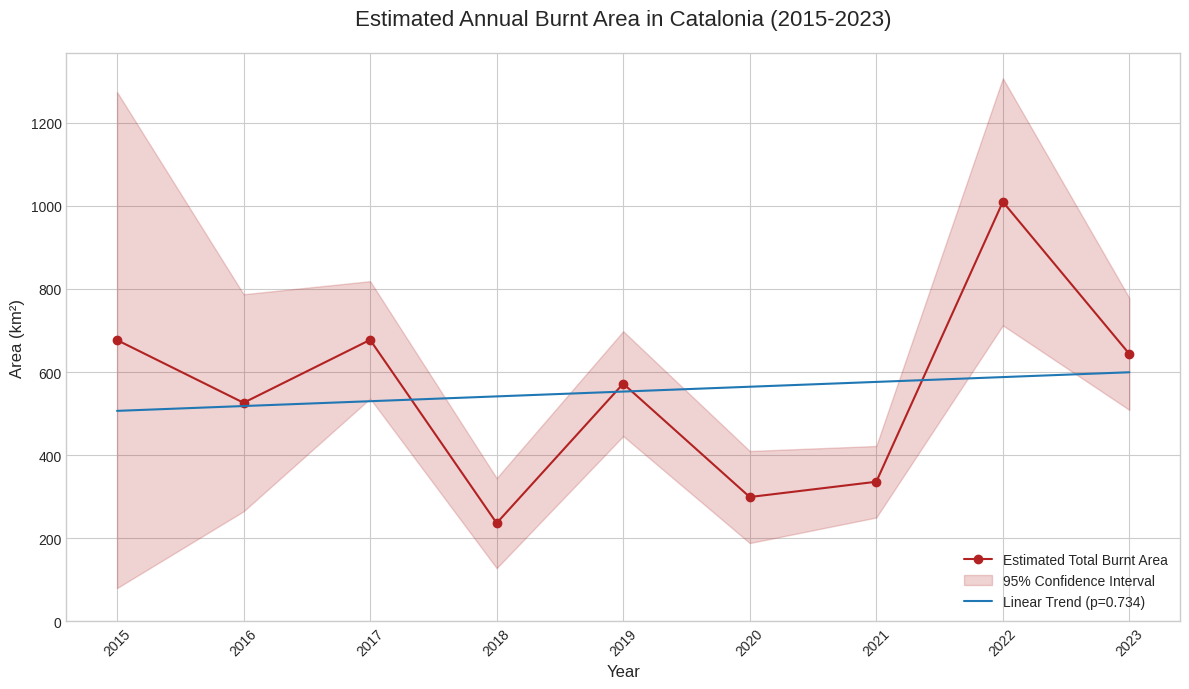


--- Linear Regression Results for Burnt Area Trend ---
Slope: 11.6068 km²/year
P-value: 0.7338
Conclusion: The trend is not statistically significant.


In [15]:
# --- 3. Visualize the Trend in Burnt Area ---

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Perform linear regression to find the trend line
x_trend = trends_df.index
y_trend = trends_df['Estimated_Total_Burnt_Area_km2']
slope, intercept, r_value, p_value, std_err = stats.linregress(x_trend, y_trend)

# Plot the estimated total burnt area
ax.plot(x_trend, y_trend, marker='o', linestyle='-', color='firebrick', label='Estimated Total Burnt Area')

# Add the 95% confidence interval
ax.fill_between(
    trends_df.index,
    trends_df['CI_Lower'],
    trends_df['CI_Upper'],
    color='firebrick',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Plot the linear regression trend line
ax.plot(x_trend, intercept + slope * x_trend, '-', label=f'Linear Trend (p={p_value:.3f})')

# Formatting the plot
ax.set_title('Estimated Annual Burnt Area in Catalonia (2015-2023)', fontsize=16, pad=20)
ax.set_ylabel('Area (km²)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_xticks(trends_df.index)
plt.xticks(rotation=45)
ax.legend()
ax.set_ylim(bottom=0) # Ensure y-axis starts at 0

plt.tight_layout()
plt.show()

# Print the statistical results for the trend
print("\n--- Linear Regression Results for Burnt Area Trend ---")
print(f"Slope: {slope:.4f} km²/year")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusion: The trend is statistically significant.")
else:
    print("Conclusion: The trend is not statistically significant.")

## 3.2. Of the total area burned each year, has severity increased?

### Visualization of the proportion of burnt area per severity class

In [14]:
# --- 1. Calculate Severity Proportions per Fire ---

severity_stats = {}

for year, fires in fire_stats.items():
    severity_stats[year] = []
    for fire_id, stats in fires.items():
        total_burnt_pixels = stats['total_burnt_pixels']
        
        if total_burnt_pixels > 0:
            # Calculate proportion of each severity class (1-4) relative to the burnt area
            proportions = {
                f'Severity_{i}_Prop': stats['class_pixels'][i] / total_burnt_pixels
                for i in range(1, 5)
            }
            severity_stats[year].append(proportions)

print("Calculated severity proportions for each fire.")

Calculated severity proportions for each fire.


In [16]:
# --- 2. Aggregate Yearly Severity Proportions and CIs ---

yearly_severity_analysis = []

for year in sorted(severity_stats.keys()):
    
    # Create a DataFrame from the list of proportion dictionaries for the year
    year_df = pd.DataFrame(severity_stats[year])
    
    if year_df.empty:
        continue
        
    # Calculate mean and 95% CI for each severity proportion
    summary = {'Year': int(year)}
    for col in year_df.columns:
        mean_prop = year_df[col].mean()
        
        if len(year_df[col]) > 1:
            std_err = year_df[col].std(ddof=1) / np.sqrt(len(year_df[col]))
            ci_margin = 1.96 * std_err
        else:
            ci_margin = 0
            
        summary[f'{col}_Mean'] = mean_prop
        summary[f'{col}_CI_Lower'] = mean_prop - ci_margin
        summary[f'{col}_CI_Upper'] = mean_prop + ci_margin
        
    yearly_severity_analysis.append(summary)

# Create a DataFrame for easier plotting
severity_df = pd.DataFrame(yearly_severity_analysis).set_index('Year')
print("\nYearly Burn Severity Proportions:")
display(severity_df[[col for col in severity_df.columns if 'Mean' in col]].head())


Yearly Burn Severity Proportions:


,Severity_1_Prop_Mean,Severity_2_Prop_Mean,Severity_3_Prop_Mean,Severity_4_Prop_Mean
Year,,,,
2015,0.983737,0.009638,0.000552,0.006073
2016,0.950653,0.017912,0.006239,0.025196
2017,0.908691,0.031887,0.001763,0.057659
2018,0.937355,0.010589,0.000139,0.051917
2019,0.918426,0.023071,0.003821,0.054681


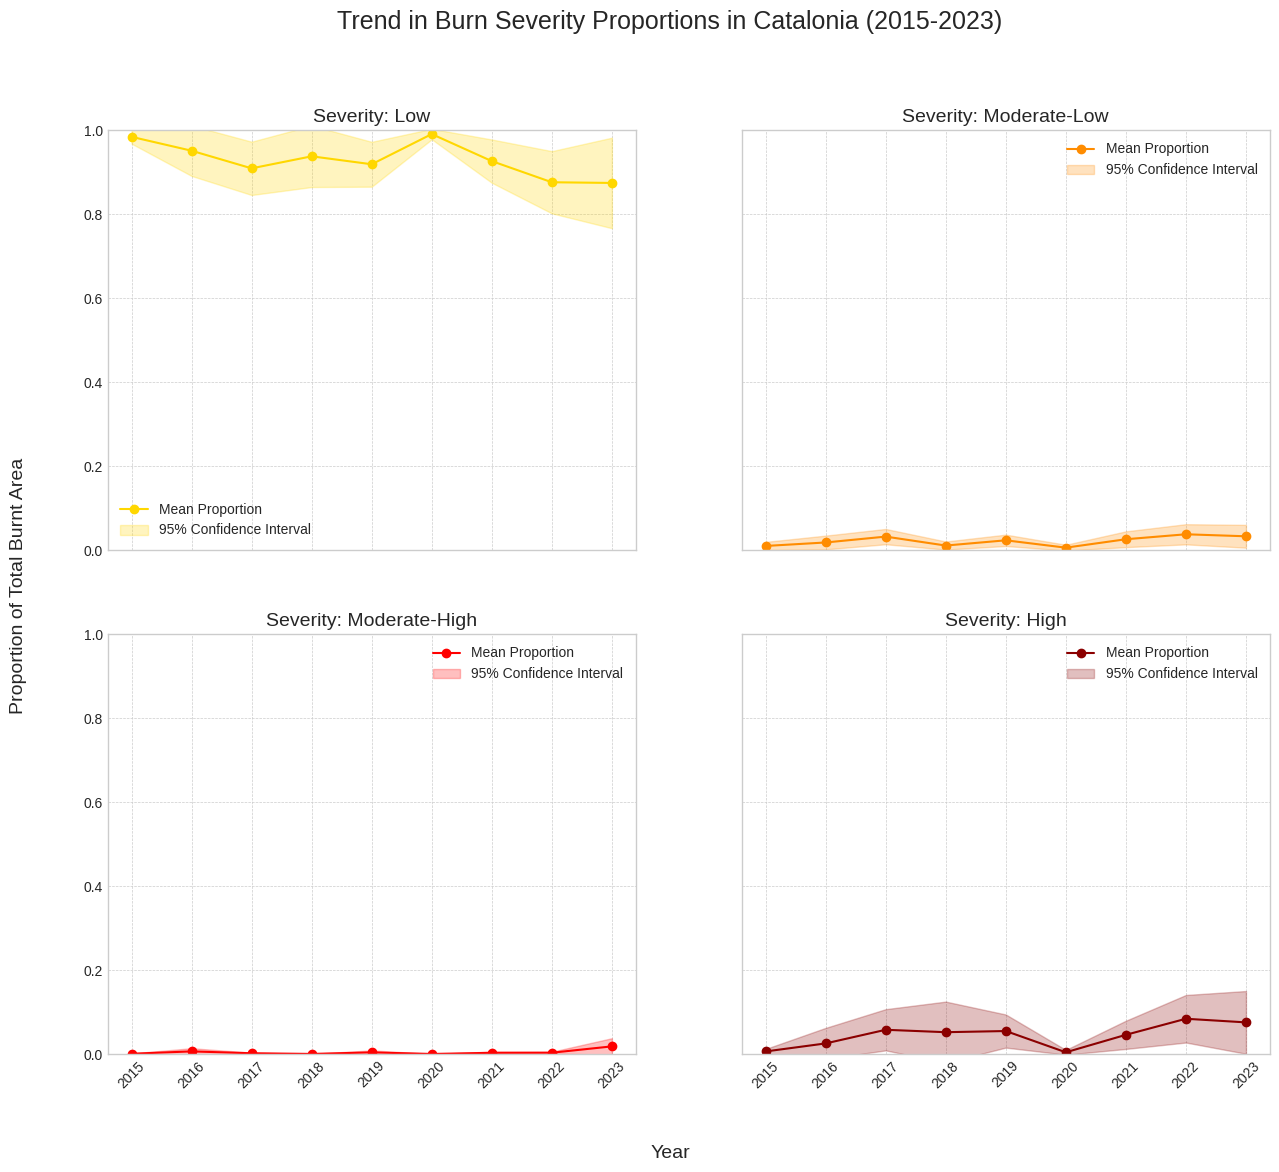

In [19]:
# --- 3. Visualize the Trend in Burn Severity ---

# Define labels and colors for severity classes
severity_labels = {
    1: 'Low',
    2: 'Moderate-Low',
    3: 'Moderate-High',
    4: 'High'
}
severity_colors = {
    1: 'gold',
    2: 'darkorange',
    3: 'red',
    4: 'darkred'
}

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 2x2 array for easy iteration

# Plot each severity class on its own subplot
for i in range(1, 5):
    ax = axes[i-1]
    mean_col = f'Severity_{i}_Prop_Mean'
    ci_lower_col = f'Severity_{i}_Prop_CI_Lower'
    ci_upper_col = f'Severity_{i}_Prop_CI_Upper'
    
    # Plot the mean proportion line
    ax.plot(severity_df.index, severity_df[mean_col], marker='o', linestyle='-', 
            color=severity_colors[i], label='Mean Proportion')
    
    # Plot the 95% confidence interval
    ax.fill_between(
        severity_df.index,
        severity_df[ci_lower_col],
        severity_df[ci_upper_col],
        color=severity_colors[i],
        alpha=0.25,
        label='95% Confidence Interval'
    )
    
    # Formatting for each subplot
    ax.set_title(f'Severity: {severity_labels[i]}', fontsize=14)
    ax.set_xticks(severity_df.index)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set common labels and a main title for the entire figure
fig.supxlabel('Year', fontsize=14, y=0.02)
fig.supylabel('Proportion of Total Burnt Area', fontsize=14, x=0.06)
fig.suptitle('Trend in Burn Severity Proportions in Catalonia (2015-2023)', fontsize=18, y=0.98)

# Set shared y-axis limits for better comparison
plt.ylim(0, 1)

# Adjust layout to prevent titles and labels from overlapping
plt.show()

### Hypothesis testing

Let's do a hypothesis test to assess if there has been a significant trend in wildfire severity over the years.

This approach uses a simple linear regression to test the relationship between the year and a calculated "average severity score".

1.  **Average Severity Score**: To perform a trend analysis, we first need a single metric for severity for each year. We can create a weighted average where each severity class is assigned a numerical weight (e.g., Low=1, Moderate-Low=2, Moderate-High=3, High=4). The average severity for a year is then the sum of `(mean_proportion_of_class * weight_of_class)`. This gives us a single, continuous variable representing the overall severity for each year.

2.  **Hypothesis Testing with Linear Regression**: We can test for a trend by regressing the `Average_Severity` score against the `Year`.
    *   **Null Hypothesis (H₀)**: There is no linear trend in the average severity over time. (The slope of the regression line is 0).
    *   **Alternative Hypothesis (H₁)**: There is a linear trend in the average severity over time. (The slope is not 0).

3.  **Interpreting the p-value**: The `p-value` from the regression will tell us the probability of observing our data if the null hypothesis (no trend) were true. A small p-value (lower than the significance level, like < 0.05) suggests that the observed trend is statistically significant, and we can reject the null hypothesis.

Average Severity Score per Year:
      Average_Severity
Year                  
2015          1.028961
2016          1.105978
2017          1.208389
2018          1.166618
2019          1.194757
2020          1.017880
2021          1.168242
2022          1.295286
2023          1.294758

--- Linear Regression Results for Severity Trend ---
Slope: 0.0234
P-value: 0.0639
R-squared: 0.4084

--- Conclusion ---
The p-value (0.0639) is greater than 0.05.
We fail to reject the null hypothesis. There is no statistically significant linear trend in wildfire severity over the years.


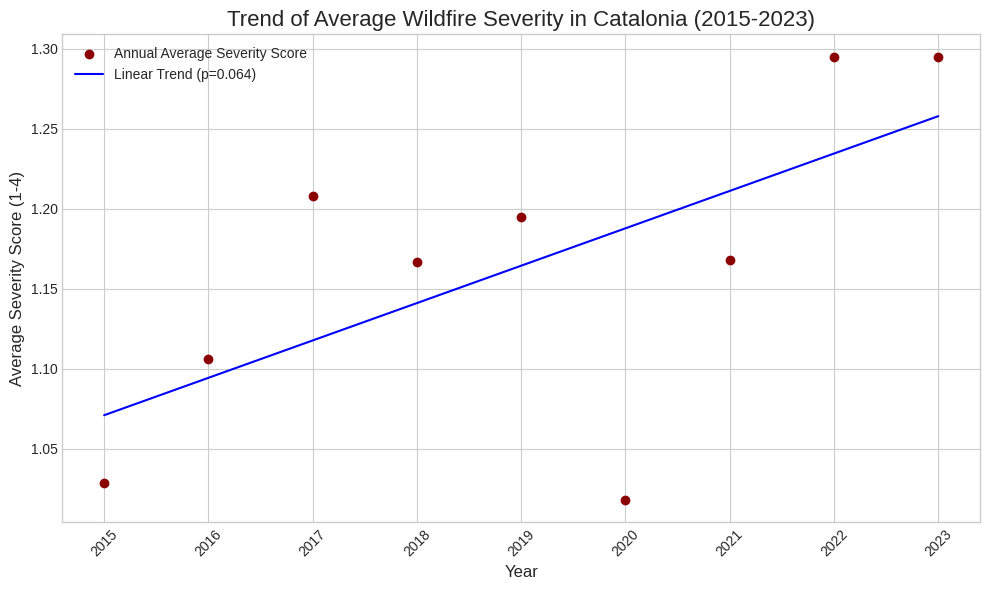

In [23]:
# --- 1. Calculate a Weighted Average Severity Score for Each Year ---

# Assign weights to each severity class
severity_weights = {1: 1, 2: 2, 3: 3, 4: 4}  # Low=1, Moderate-Low=2, etc.

# Calculate the weighted average score
severity_df['Average_Severity'] = (
    severity_df['Severity_1_Prop_Mean'] * severity_weights[1] +
    severity_df['Severity_2_Prop_Mean'] * severity_weights[2] +
    severity_df['Severity_3_Prop_Mean'] * severity_weights[3] +
    severity_df['Severity_4_Prop_Mean'] * severity_weights[4]
)

print("Average Severity Score per Year:")
print(severity_df[['Average_Severity']])

# --- 2. Perform Linear Regression to Test for a Trend ---

# X values are the years, Y values are the average severity scores
x = severity_df.index
y = severity_df['Average_Severity']

# Perform the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# --- 3. Interpret and Display the Results ---

print("\n--- Linear Regression Results for Severity Trend ---")
print(f"Slope: {slope:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

# Set the significance level (alpha)
alpha = 0.05

print("\n--- Conclusion ---")
if p_value < alpha:
    print(f"The p-value ({p_value:.4f}) is less than {alpha}.")
    if slope > 0:
        print("We reject the null hypothesis. There is a statistically significant INCREASING trend in wildfire severity over the years.")
    else:
        print("We reject the null hypothesis. There is a statistically significant DECREASING trend in wildfire severity over the years.")
else:
    print(f"The p-value ({p_value:.4f}) is greater than {alpha}.")
    print("We fail to reject the null hypothesis. There is no statistically significant linear trend in wildfire severity over the years.")

# --- 4. Visualize the Trend ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of the data
ax.scatter(x, y, label='Annual Average Severity Score', color='darkred', zorder=5)

# Plot the regression line
ax.plot(x, intercept + slope*x, 'b-', label=f'Linear Trend (p={p_value:.3f})')

# Formatting
ax.set_title('Trend of Average Wildfire Severity in Catalonia (2015-2023)', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Average Severity Score (1-4)', fontsize=12)
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()